In [3]:
import os
import shutil
import matplotlib.colors as mcolors
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import pydicom
import cv2

from tqdm import tqdm
from PIL import Image
from duke_dbt_data import dcmread_image
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from skimage.metrics import structural_similarity as ssim

In [4]:
pathXlsx = "D:/Codigo/Datos/CMMD/CMMD_clinicaldata_revision.xlsx"
pathRadiografias = "D:/CHINO/manifest-1616439774456/CMMD/"
pathNumpys = "D:/Numpys/CMMD"

In [56]:
def npArrayNormalized(array,tamano_cuadrado):
    array_uint8 = array.astype(np.uint16)
    array_byte0 = (array_uint8 & 0xFF).astype(np.uint8)
    array_byte1 = ((array_uint8 >> 8) & 0xFF).astype(np.uint8)
    array_byte01 = []
    array_byte11 = []
    
    for i in range(array.shape[0]):  # Recorrer la dimensión 0 del array
        # Redimensionar y agregar los bytes a las listas
        array_byte01.append(cv2.resize(array_byte0[i], (tamano_cuadrado, tamano_cuadrado)))
        array_byte11.append(cv2.resize(array_byte1[i], (tamano_cuadrado, tamano_cuadrado)))
    
    # Convertir las listas de bytes a arrays de NumPy
    array_byte01 = np.array(array_byte01)
    array_byte11 = np.array(array_byte11)
    
    arrays = [array_byte01, array_byte11]
    
    arrays = np.transpose(np.array(arrays), (1, 2, 3, 0))
    return arrays
    
def resizeAndSave(npArrayImag, tamano_cuadrado, ruta):
    """
    Redimensiona cada imagen en un np.ndarray y las guarda en un archivo usando np.save.

    Args:
    - npArrayImag (np.ndarray): Un array de NumPy que contiene las imágenes.
    - tamano_cuadrado (int): El tamaño al que se redimensionarán las imágenes (ancho y alto).
    - ruta (str): La ruta donde se guardará el archivo con las imágenes redimensionadas.
    """
    # Crear un nuevo array para almacenar las imágenes redimensionadas
    imagenes_redimensionadas = np.zeros((5, tamano_cuadrado, tamano_cuadrado))

    # Redimensionar cada imagen y guardarla en el nuevo array
    for i in range(5):
        imagen_redimensionada = cv2.resize(npArrayImag[i], (tamano_cuadrado, tamano_cuadrado))
        imgu8 = convert(imagen_redimensionada, 0, 255, np.uint8)
        imagenes_redimensionadas[i] = imgu8

    # Guardar el array de imágenes redimensionadas en un archivo
    np.save(ruta, imagenes_redimensionadas)

def combinar_imagenes(imagenes_seleccionadas):
    # Asegurarse de que tenemos al menos una imagen
    if len(imagenes_seleccionadas) > 0:
        # Convertir imagenes_seleccionadas a una matriz numpy
        imagenes_seleccionadas = np.array(imagenes_seleccionadas)
        
        # Crear un array para almacenar las imágenes reorganizadas
        imagenes_reorganizadas = np.zeros((1440,1440), dtype=np.uint8)
        
        # Iterar sobre cada imagen y colocarla en su posición deseada
        for i, img in enumerate(imagenes_seleccionadas[:4]):
            if i == 0:  # Parte superior izquierda
                imagenes_reorganizadas[:720, :720] = img.astype(np.uint8)
            elif i == 1:  # Parte superior derecha
                imagenes_reorganizadas[720:, :720] = img.astype(np.uint8)
            elif i == 2:  # Parte inferior izquierda
                imagenes_reorganizadas[:720, 720:] = img.astype(np.uint8)
            elif i == 3:  # Parte inferior derecha
                imagenes_reorganizadas[720:, 720:] = img.astype(np.uint8)

        return imagenes_reorganizadas
    else:
        print("Error: No se han seleccionado imágenes.")
    #print(imagenes_reorganizadas.shape)
    
# Ejemplo de uso
# Suponiendo que tienes una lista de imágenes llamada imagenes_seleccionadas
# Llamamos a la función con esta lista de imágenes
# resultado = combinar_imagenes(imagenes_seleccionadas)

Forma del array: (4, 720, 720)


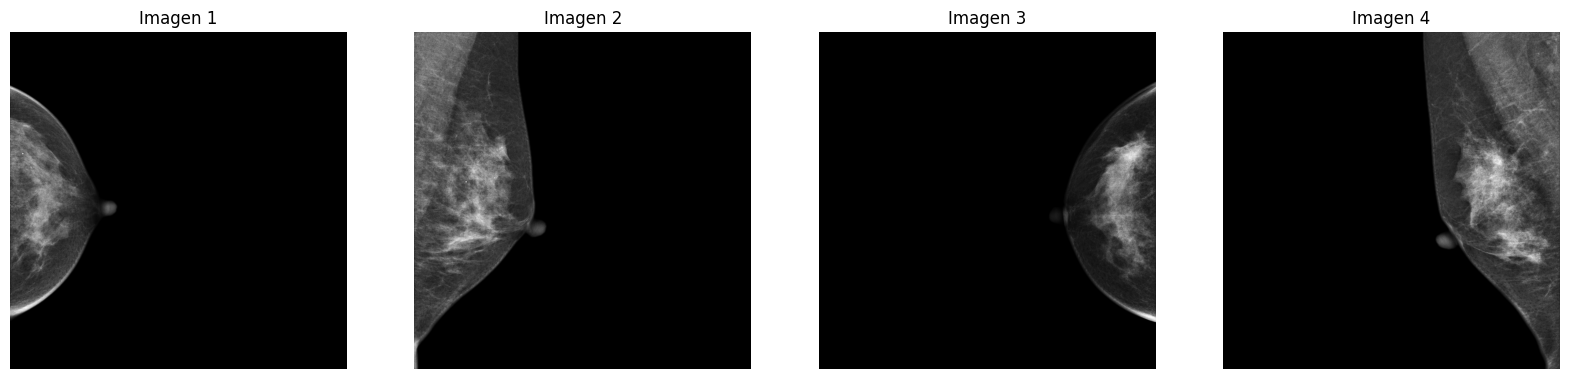

In [11]:
# Ruta del archivo .npy
ruta_imagen = "E:/Numpys/CMMD/Array/Malignant/D2-0273.npy"

# Cargar el archivo .npy
imagenes = np.load(ruta_imagen)

# Comprobar la forma del array cargado
print(f"Forma del array: {imagenes.shape}")

# Mostrar las imágenes
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(imagenes[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Imagen {i+1}')

plt.show()

Dimensiones de la imagen guardada: (4, 720, 720)
Dimensiones de la imagen guardada: (554, 554)


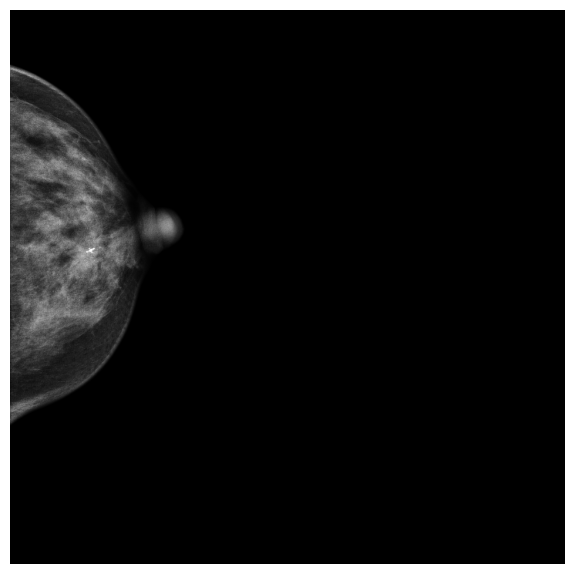

In [8]:
ruta_imagen = "E:/Numpys/CMMD/Array/Malignant/D2-0275.npy"  # Reemplaza con la ruta de tu archivo DICOM

# Cargar el array numpy
array_cargado = np.load(ruta_imagen)
print("Dimensiones de la imagen guardada:", array_cargado.shape)

# Ajustar el tamaño de la figura para que coincida con las dimensiones de la imagen
dimensiones = array_cargado[0].shape[::-1]  # Invertir las dimensiones para que coincidan con la imagen
plt.figure(figsize=(dimensiones[0] / 100, dimensiones[1] / 100))  # Convertir píxeles a pulgadas (100 DPI)
plt.imshow(array_cargado[0], cmap=plt.cm.gray)
plt.axis('off')  # Desactivar ejes

# Guardar la imagen como PNG
ruta_guardado = "imagen.png"  # Ruta donde quieres guardar la imagen
plt.savefig(ruta_guardado, bbox_inches='tight', pad_inches=0)  # Ajustar los márgenes

# Obtener las dimensiones de la imagen guardada
imagen_guardada = plt.imread(ruta_guardado)
dimensiones_guardadas = imagen_guardada.shape[:2]

print("Dimensiones de la imagen guardada:", dimensiones_guardadas)


In [57]:
# Leer el archivo CSV
df = pd.read_excel(pathXlsx)  # Usar read_excel para leer archivos xlsx

# Tamaño cuadrado deseado para las imágenes (en píxeles)
tamano_cuadrado = 720

# Iterar sobre las filas del DataFrame df
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Cargando imagen"):
    
    ruta_imagen = os.path.join(pathRadiografias, str(row["ID1"]))
    
    if os.path.exists(ruta_imagen):
        group_arrays = []  # Lista para almacenar los arreglos de cada grupo de archivos DICOM
        
        for root, dirs, files in os.walk(ruta_imagen):
            dcm_files = [f for f in files if f.endswith(".dcm")]
            if dcm_files:
                for file in dcm_files:
                    ruta_archivo_dcm = os.path.join(root, file)
                    # Leer archivo DICOM
                    dcm_data = pydicom.dcmread(ruta_archivo_dcm)
                    pixel_array = dcm_data.pixel_array
                    # Normalizar y redimensionar los datos
                    resized_array = cv2.resize(pixel_array, (tamano_cuadrado, tamano_cuadrado))
                    # Agregar los datos a la lista del grupo
                    group_arrays.append(resized_array)
                    # roww = str(row["ID1"])
                    # print(f"Guardando : {roww}")

        
        # Concatenar los arreglos de cada grupo en un solo arreglo
        if group_arrays:
            nombre_archivo_numpy = str(row["ID1"]) + ".npy"
            # Determinar a qué colección agregar la imagen según los valores de las columnas
            if row["classification"] == "Benign":
                np.save(os.path.join(f"{pathNumpys}/Benign", nombre_archivo_numpy), group_arrays)
            if row["classification"] == "Malignant":
                np.save(os.path.join(f"{pathNumpys}/Malignant", nombre_archivo_numpy), group_arrays)

Cargando imagen: 100%|█████████████████████████████████████████████████████████████| 1872/1872 [04:43<00:00,  6.61it/s]


# 4 imagenes en 1

In [58]:
# Benign
pathNumpySave = "E:/Numpys/CMMD/Benign"
pathNumpy = "D:/Numpys/CMMD/Benign"

# Obtener la lista de archivos en el directorio
archivos = os.listdir(pathNumpy)

# Iterar sobre los archivos y mostrar el progreso
for archivo in tqdm(archivos, desc="Procesando archivos"):
    # Inicializa la imagen final como una matriz de ceros
    ruta_archivo = os.path.join(pathNumpy, archivo)
    array_cargado = np.load(ruta_archivo)# Cargar el array numpy
    resultado = combinar_imagenes(array_cargado)
    
    ruta_archivo = os.path.join(pathNumpySave,archivo)
    np.save(ruta_archivo, resultado)

Procesando archivos: 100%|███████████████████████████████████████████████████████████| 495/495 [00:10<00:00, 47.98it/s]


In [61]:
# Malignant
pathNumpySave = "E:/Numpys/CMMD/Malignant"
pathNumpy = "D:/Numpys/CMMD/Malignant"

# Obtener la lista de archivos en el directorio
archivos = os.listdir(pathNumpy)

# Iterar sobre los archivos y mostrar el progreso
for archivo in tqdm(archivos, desc="Procesando archivos"):
    # Inicializa la imagen final como una matriz de ceros
    ruta_archivo = os.path.join(pathNumpy, archivo)
    array_cargado = np.load(ruta_archivo)# Cargar el array numpy
    resultado = combinar_imagenes(array_cargado)
    
    ruta_archivo = os.path.join(pathNumpySave,archivo)
    np.save(ruta_archivo, resultado)

Procesando archivos: 100%|█████████████████████████████████████████████████████████| 1310/1310 [00:26<00:00, 50.18it/s]


# ------------------------------ Comparar y seleccionar imágenes --------------------------------

In [95]:
# Benign
pathNumpy = "E:/Numpys/CMMD/Benign"
pathNumpySave = "E:/Numpys/CMMD_NumpysSeleccionadas/Benign"
NumImagenes = 280 - 112  # Img Cancer Validation dataset

# Lista para almacenar las rutas de los archivos .npy
rutas_archivos = []
for filename in os.listdir(pathNumpy):
    if filename.endswith(".npy"):
        rutas_archivos.append(os.path.join(pathNumpy, filename))

# Mostrar la cantidad de archivos en rutas_archivos
print("Cantidad de archivos .npy encontrados:", len(rutas_archivos))

archivo_progreso = "progresoCMMDSeleccionBenign.npy"
# Comprobar si existe un archivo de progreso guardado
if os.path.exists(archivo_progreso):
    print("Cargando progreso previo...")
    ssim_scores_promedio = np.load(archivo_progreso)
else:
    ssim_scores_promedio = np.empty((0, 2))

# Calcular SSIM entre cada archivo y todos los demás archivos
for i, ruta_i in enumerate(rutas_archivos):
    if i >= len(ssim_scores_promedio):  # Continuar desde donde se quedó
        archivo_i = np.load(ruta_i)
        scores_i = []
        for j, ruta_j in enumerate(rutas_archivos):
            if i != j:  # Evitar comparar un archivo consigo mismo
                archivo_j = np.load(ruta_j)
                score, _ = ssim(archivo_i, archivo_j, full=True)
                print(f"Calculando: {i} - {j}  Total: {len(rutas_archivos)}    ", end='\r') 
                scores_i.append(score)
        ssim_scores_promedio = np.vstack([ssim_scores_promedio, [i, np.mean(scores_i)]])
        np.save(archivo_progreso, ssim_scores_promedio)

# Ordenar los scores promedio de menor a mayor
sorted_indices = np.argsort(ssim_scores_promedio[:, 1])

# Seleccionar los primeros NumImagenes
indices_seleccionados = sorted_indices[:NumImagenes]
print(indices_seleccionados)
# Guardar los archivos seleccionados con sus nombres originales
for idx in indices_seleccionados:
    nombre_original = os.path.basename(rutas_archivos[idx])  # Obtener el nombre original del archivo
    np.save(os.path.join(pathNumpySave, nombre_original), np.load(rutas_archivos[idx]))
print("Fin")

Cantidad de archivos .npy encontrados: 495
Cargando progreso previo...
[203 281 488 222 195  31  49 480  57 355 391  68 116 367  46 298 493 492
  44  85 311 368  51 312 487  47 375 489  43 313 344 228 252 486 481 328
  92 479 289 113 111 435 106   7 365 400 485  64 115 279 114 144 238 309
 200 482  48  33 426 310 340 427 256 181 483 374   8 220  70 416 442 251
  23 107 224 330 445 149  38 491 254  90 318 450 449  39 433 273  45 320
 264 214  29  74 152 299 242  52 239 265 390 353 117   4 270 237 366 409
 463 494 124 341 422 382 381 146 123 206   9 454 223  84 465 230 396 142
 257  65  15  53 484  62 447  86 178 490 119 284 438 110 315  34  61 434
 187 455 227 466 410  40 161 262  20 468 470 272 305 338 332 412  56 331
 472  91 198  17  22 415]
Fin


In [3]:
ruta1 = "progresoCMMDSeleccionMalignant1.npy"
ruta2 = "progresoCMMDSeleccionMalignant2.npy"

lista1 = np.load(ruta1)
lista2 = np.load(ruta2)

# Combinar los ssim_scores_promedio
ssim_scores_combinado = np.concatenate((lista1, lista2))

print("Dimensiones del array combinado:", ssim_scores_combinado.shape)

np.save("progresoCMMDSeleccionMalignant.npy", ssim_scores_combinado)

Dimensiones del array combinado: (1310, 2)


In [7]:
# Malignant
pathNumpy = "D:/Numpys/CMMD/Malignant"
pathNumpySave = "E:/Numpys/DBT/ArraySelecionadas/Cancer"
NumImagenes = 607 - 89  # Img Cancer Validation dataset

# Lista para almacenar las rutas de los archivos .npy
rutas_archivos = []
for filename in os.listdir(pathNumpy):
    if filename.endswith(".npy"):
        rutas_archivos.append(os.path.join(pathNumpy, filename))

# Mostrar la cantidad de archivos en rutas_archivos
print("Cantidad de archivos .npy encontrados:", len(rutas_archivos))

archivo_progreso = "progresoCMMDSeleccionMalignant.npy"
# Comprobar si existe un archivo de progreso guardado
if os.path.exists(archivo_progreso):
    print("Cargando progreso previo...")
    ssim_scores_promedio = np.load(archivo_progreso)
else:
    ssim_scores_promedio = np.empty((0, 2))

# Calcular SSIM entre cada archivo y todos los demás archivos
for i, ruta_i in enumerate(rutas_archivos):
    if i >= len(ssim_scores_promedio):  # Continuar desde donde se quedó
        archivo_i = np.load(ruta_i)
        scores_i = []
        for j, ruta_j in enumerate(rutas_archivos):
            if i != j:  # Evitar comparar un archivo consigo mismo
                archivo_j = np.load(ruta_j)
                score, _ = ssim(archivo_i, archivo_j, full=True)
                print(f"Calculando: {i} - {j}  Total: {len(rutas_archivos)}    ", end='\r') 
                scores_i.append(score)
        ssim_scores_promedio = np.vstack([ssim_scores_promedio, [i, np.mean(scores_i)]])
        np.save(archivo_progreso, ssim_scores_promedio)

# Ordenar los scores promedio de menor a mayor
sorted_indices = np.argsort(ssim_scores_promedio[:, 1])

# Seleccionar los primeros NumImagenes
indices_seleccionados = sorted_indices[:NumImagenes]
print(indices_seleccionados)
# Guardar los archivos seleccionados con sus nombres originales
for idx in indices_seleccionados:
    nombre_original = os.path.basename(rutas_archivos[idx])  # Obtener el nombre original del archivo
    np.save(os.path.join(pathNumpySave, nombre_original), np.load(rutas_archivos[idx]))
print("Fin")

Cantidad de archivos .npy encontrados: 1310
Cargando progreso previo...
[1174  928 1011 1231  793  975 1205 1201  916 1196  923  775  830  859
  519 1034 1308  789 1237  965  773  670 1304 1279  723  419 1019  652
 1143 1246  781 1210 1087  225  721  313 1059  398  137 1027 1190  963
 1015  601  448 1043  466  224 1032  672  784  803 1167 1121  371   80
  417 1060  379 1058  752  470  926 1219  758  246 1164  771  522 1077
  444 1033  968  953 1218  914  296 1126  537  915  805 1066  531  514
 1005  410  811 1056 1278  977  639   42 1175 1239  280  828  857 1170
  193  903 1130  489 1124 1031 1097  266  134  325  688  357  183  689
 1039   81 1008  510  429  427  547  320  919  779  342 1114 1263  428
  316  382   77  153  921  449 1302  286  307  396  538  375 1198 1045
  230 1064  493 1257  322  359  480  657  766  354    2   50  730  463
  986 1131  279 1020   76 1028  200  441  235  984  683 1075  189  712
  376  971 1197 1277  647  497   69  499  350  314  544  482  869  840
  161